In [83]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import useful_scit.util.log as log
log.ger.setLevel(log.log.INFO)
import xarray as xr

import matplotlib.pyplot as plt
from bs_fdbck.constants import path_extract_latlon_outdata
from dask.diagnostics import ProgressBar

from bs_fdbck.util.imports import import_fields_xr_echam

from bs_fdbck.util.BSOA_datamanip import compute_total_tau, broadcase_station_data, change_units_and_compute_vars, \
    get_dic_df_mod, change_units_and_compute_vars_echam, extract_2D_cloud_time_echam, rn_dic_echam_cloud,rn_dic_noresm_cloud

from bs_fdbck.util.BSOA_datamanip import fix_echam_time

import pandas as pd

In [85]:
from timeit import default_timer as timer



from dask.diagnostics import ProgressBar

from bs_fdbck.util.BSOA_datamanip.atto import season2month

In [86]:

select_station = 'ATTO'

In [87]:
xr.set_options(keep_attrs=True) 

In [88]:
calc_seasons = ['ALL_year']

In [89]:
tau_lims = [5,50]
r_eff_lim = 1
cloud_top_temp_above = -15 
cld_water_path_above = 50
#include_months = [7,8]

In [90]:
from bs_fdbck.constants import path_measurement_data
postproc_data = path_measurement_data /'model_station'/select_station
postproc_data_obs = path_measurement_data /select_station/'processed'



In [91]:
lon_lims = [293.,308.]
lat_lims = [-8.,-1.]

lat_smr = -2.150
lon_smr = 360-59.009
model_lev_i=-2


temperature = 273.15  # K


from_time1 = '2012-01-01'
to_time1 = '2015-01-01'
from_time2 ='2015-01-01'
to_time2 ='2019-01-01'
sel_years_from_files = ['2012','2014','2015','2018']

## Daytime values


Set the daytime to be from 10 to 17 each day

In [92]:
daytime_from = 9
daytime_to = daytime_from + 7

## Read in model station data:

In [93]:
models = ['ECHAM-SALSA','NorESM','EC-Earth']
mod2cases = {'ECHAM-SALSA':['SALSA_BSOA_feedback'],
             'NorESM':['OsloAero_intBVOC_f09_f09_mg17_fssp'],
             'EC-Earth':['ECE3_output_Sara'],
            }
di_mod2cases = mod2cases.copy()

In [94]:
dic_df_station=dict()
for mod in models:
    print(mod)
    dic_df_station[mod] = dict()
    for ca in mod2cases[mod]:
        print(mod, ca)
        fn_out = postproc_data/f'{select_station}_station_{mod}_{ca}.csv'
        print(fn_out)
        dic_df_station[mod][ca] = pd.read_csv(fn_out, index_col=0)
        dic_df_station[mod][ca].index = pd.to_datetime(dic_df_station[mod][ca].index)
        #dic_df_mod_case[mod][ca].to_csv(fn_out)

ECHAM-SALSA
ECHAM-SALSA SALSA_BSOA_feedback
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_ECHAM-SALSA_SALSA_BSOA_feedback.csv
NorESM
NorESM OsloAero_intBVOC_f09_f09_mg17_fssp
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_NorESM_OsloAero_intBVOC_f09_f09_mg17_fssp.csv
EC-Earth
EC-Earth ECE3_output_Sara
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/model_station/ATTO/ATTO_station_EC-Earth_ECE3_output_Sara.csv


<AxesSubplot:xlabel='time'>

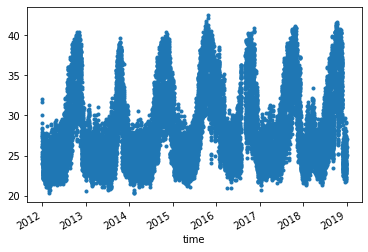

In [95]:
dic_df_station[mod][ca]['T_C'].plot(marker='.')

## EC-Earth

### Names etc

In [96]:

case_name = 'ECE3_output_Sara'
case_name_ec_earth = 'ECE3_output_Sara'
time_res = 'hour'
space_res='locations'
model_name='EC-Earth'
model_name_ec_earth ='EC-Earth'

### Input path:

In [97]:
input_path_ec_earth = path_extract_latlon_outdata / model_name_ec_earth / case_name_ec_earth

In [98]:

cases_ec_earth = [case_name_ec_earth]

### Station variables  and others

### Define some strings for files

In [99]:

str_from_t = pd.to_datetime(from_time1).strftime('%Y%m')
str_to = pd.to_datetime(to_time2).strftime('%Y%m')
str_lonlim = '%.1f-%.1f'%(*lon_lims,)
str_latlim = '%.1f-%.1f'%(*lat_lims,)
str_coordlims = f'{str_lonlim}_{str_latlim}'
str_coordlims

'293.0-308.0_-8.0--1.0'

### Filenames: 

In [100]:
fn_intermediate_ec_earth = input_path_ec_earth/ f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_intermediate.nc'
fn_intermediate_ec_earth_lev = input_path_ec_earth/ f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}_intermediate_lev.nc'

fn_final_ec_earth = input_path_ec_earth/ f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.nc'
fn_final_ec_earth_csv = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}.csv'
fn_final_ec_earth_csv_stem = input_path_ec_earth / f'{case_name}_{from_time1}-{to_time2}_ALL-VARS_concat_subs_{str_coordlims}'

In [101]:
fn_final_ec_earth_csv_stem

PosixPath('/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_2012-01-01-2019-01-01_ALL-VARS_concat_subs_293.0-308.0_-8.0--1.0')

### Open data

In [102]:
which='IFS'

In [103]:
fn_t = input_path_ec_earth / f'{case_name}_{which}_{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'


In [104]:
fn_t.exists()

True

In [105]:
fl_open = []
#ds_list =[]
dic_ds =dict()

for which in ['IFS','IFS_T']:
    fn = input_path_ec_earth / f'{case_name}_{which}_{from_time1}-{to_time2}_concat_subs_{str_coordlims}.nc'
    print(fn)
    if fn.exists():
        fl_open.append(fn)
        _ds = xr.open_dataset(fn)
        dic_ds[which] = _ds
    else:
        print(f'{v} not found')
        

/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_IFS_2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0.nc
/proj/bolinc/users/x_sarbl/analysis/Output_data_BS-FDBCK/extracted_latlon_subset/EC-Earth/ECE3_output_Sara/ECE3_output_Sara_IFS_T_2012-01-01-2019-01-01_concat_subs_293.0-308.0_-8.0--1.0.nc


### Open files, decode time, drop excess coords, select bottom layer, broadcast station vars to whole grid and compute units etc

In [106]:
dic_df_station[model_name_ec_earth][case_name_ec_earth].head()

,station,time_orig,lev,CCN0.20,CCN1.00,M_BCACS,M_BCAII,M_BCAIS,M_BCCOS,M_DUACI,...,N150-500,N200-500,OA,POM,SOA,SOA2,T_C,is_JJA,is_JA,isSummer
time,,,,,,,,,,,,,,,,,,,,,
2011-12-31 20:00:00,ATTO,2012-01-01 00:30:00.000000000,2.0,104.46652,169.93945,7.749801e-11,1.195486e-11,5.233935e-13,1.018316e-14,4.597259e-10,...,100.961462,71.034853,1.762270,0.664647,1.097623,1.097623,NaN,False,False,False
2011-12-31 21:00:00,ATTO,2012-01-01 01:30:00.000000000,2.0,104.66638,170.33379,7.789928e-11,1.206712e-11,5.107936e-13,1.031701e-14,4.591339e-10,...,101.024142,71.109470,1.764701,0.667787,1.096914,1.096914,NaN,False,False,False
2011-12-31 22:00:00,ATTO,2012-01-01 02:30:00.000000000,2.0,104.61212,170.43909,7.815295e-11,1.211496e-11,5.031363e-13,1.039341e-14,4.575842e-10,...,100.819331,70.990696,1.759449,0.669758,1.089691,1.089691,NaN,False,False,False
2011-12-31 23:00:00,ATTO,2012-01-01 03:30:00.000000000,2.0,104.51892,170.58879,7.841911e-11,1.214463e-11,4.996820e-13,1.044115e-14,4.560449e-10,...,100.559394,70.822420,1.750940,0.671862,1.079078,1.079078,27.902313,False,False,False
2012-01-01 00:00:00,ATTO,2012-01-01 04:30:00.000000000,2.0,104.40431,170.79070,7.870423e-11,1.216151e-11,4.994802e-13,1.048248e-14,4.545686e-10,...,100.263232,70.621023,1.739966,0.674125,1.065841,1.065841,NaN,False,False,False


In [107]:
from bs_fdbck.util.BSOA_datamanip.ec_earth import (
    rename_ifs_vars,
    fix_units_ec_earth,
    extract_cloud_top,
    calculate_incld_values_warmclouds,
    make_dummy_lev,
    
)

## Fix units, calc cloud properties etc.

In [ ]:
if True:#not fn_intermediate_ec_earth.exists():
    

    for key in dic_ds:
        _ds = dic_ds[key]
        _ds=rename_ifs_vars(_ds)
        
        _ds = fix_units_ec_earth(_ds)
        #_ds = calculate_incld_values_warmclouds(_ds)
        #_ds = extract_cloud_top(_ds)
        #_ds['lat'] = np.round(_ds['lat'], decimals=2)
        #_ds['lon'] = np.round(_ds['lon'], decimals=2)
        _ds = _ds.sortby('lon')
        _ds = _ds.sortby('lat')
        _ds=(
            _ds
            .assign(
                lat=lambda d:d['lat'].astype('float').round(2))
            .assign(
                lon=lambda d:d['lon'].astype('float').round(2))
        )

        dic_ds[key] = _ds
    

    ds = dic_ds['IFS']
    

    ds = calculate_incld_values_warmclouds(ds)
    

    ds = extract_cloud_top(ds)
    
    dic_ds['IFS'] = ds

    for key in dic_ds:
        _ds = dic_ds[key]
        ds_l = _ds.isel(lev= model_lev_i)
        dic_ds[key] = ds_l

  

      
    ds_t = dic_ds['IFS_T']
    
    ds = dic_ds['IFS']
    ds = ds.sortby('lat')
    ds = ds.sortby('lon')

    ds_t['lev'] = ds['lev']
    ds_t = ds_t.sortby('lat')
    ds_t = ds_t.sortby('lon')
    ds_t['temp'].plot()
    plt.show()

    drop_list = ['U','V','temp']
    ds = xr.merge([ds.drop_vars(drop_list).drop_dims(['plev']),ds_t[['temp']]])
    ds['temp'].plot()
    plt.show()
    

    # ds =fix_units_ec_earth(ds)
    # ds = calculate_incld_values_warmclouds(ds)
    # ds = extract_cloud_top(ds)

    delayed_obj = ds.to_netcdf(fn_intermediate_ec_earth, compute=False)
    with ProgressBar():
        delayed_obj.compute()
    

renaming var130 to temp
renaming var131 to U
renaming var132 to V
renaming var136 to tcw
renaming var137 to tcwv
renaming var164 to ttc
renaming var176 to surf_net_srad
renaming var177 to surf_net_lrad
renaming var178 to toa_net_srad
renaming var179 to toa_net_lrad
renaming var20 to cdnc
renaming var208 to toa_net_srad_clear
renaming var21 to re_liq
renaming var210 to surf_net_srad_clear
renaming var211 to sur_net_lrad_clear
renaming var22 to liq_cloud_time
renaming var248 to cc
renaming var68 to toa_net_srad_clearclean
renaming var69 to toa_net_srad_clean
renaming var70 to surf_net_srad_clearclean
renaming var71 to surf_net_srad_clean
renaming var72 to toa_net_lrad_clearclean
renaming var73 to toa_net_lrad_clean
renaming var74 to surf_net_lrad_clearclean
renaming var75 to surf_net_lrad_clean
renaming var78 to tclw
renaming var79 to tciw
Converting tcw from kg/m2 to g/m2
Converting tcwv from kg/m2 to g/m2
Converting tclw from kg/m2 to g/m2
Converting tciw from kg/m2 to g/m2
renaming va

In [ ]:
fn_intermediate_ec_earth#.exists()

In [ ]:
ds_ifs = xr.open_dataset(fn_intermediate_ec_earth, decode_times=False)


In [ ]:
import numpy as np

In [ ]:
ds_ifs['re_liq_cltop'].plot(bins=np.linspace(3.99,4.01));

In [ ]:
ds_ifs['ttc'].attrs['units'] =1

In [ ]:
import numpy as np

## Fix wrong units:

In [ ]:
for v in ds_ifs.data_vars:
    if 'units' in ds_ifs[v].attrs:
        print(v, ds_ifs[v].attrs['units'])
        if ds_ifs[v].attrs['units'] is np.nan:
            print('******')
        if ds_ifs[v].attrs['units']==1:
            ds_ifs[v].attrs['units'] ='1'
            print(f'{v} unit is 1')

In [ ]:
ds_ifs = xr.decode_cf(ds_ifs)
ds_ifs['time'].attrs['timezone'] = 'utc'

In [ ]:
import numpy as np

In [ ]:
ds_ifs['cc_cltop'].plot(alpha=.5)

ds_ifs['cc_all'].plot(alpha=.5)

## Mask values where cloud fraction is less than 10 percent

In [ ]:
ds_ifs = ds_ifs.where(ds_ifs['cc_cltop']>.1)

## Shift timezone

In [ ]:
from datetime import timedelta
with ProgressBar():
    ds_ifs.load()
    
    
if ds_ifs['time'].attrs['timezone']=='utc':
    ds_ifs['time'] = ds_ifs['time'].to_pandas().index - timedelta(hours=4)
    ds_ifs['time'].attrs['timezone'] = 'utc-4'
    print('shifted time by -4')
    #dic_ds[k] = _ds

### Use station data computed before:

In [ ]:
df_comb_station = dic_df_station[model_name_ec_earth][case_name_ec_earth]

In [ ]:
ds_comb_station = df_comb_station.to_xarray()
ds_comb_station=ds_comb_station.assign_coords(station=['ATTO'])

In [ ]:
ds_ifs['temp'].plot()

In [ ]:
ds_ifs['hour'] = ds_ifs['time.hour']
(ds_ifs['temp']-273.15).groupby(ds_ifs['hour']).mean().sel(lat=lat_smr,lon=lon_smr, method='nearest').plot()
ds_comb_station['T_C'].groupby(ds_comb_station['time.hour']).mean().plot(marker='*')

In [ ]:
varl_station_ec_earth = [
 'CCN0.20',
 'CCN1.00',
 'M_BCACS',
 'M_BCAII',
 'M_BCAIS',
 'M_BCCOS',
 'M_DUACI',
 'M_DUACS',
 'M_DUCOI',
 'M_DUCOS',
 'M_POMACS',
 'M_POMAII',
 'M_POMAIS',
 'M_POMCOS',
 'M_SO4ACS',
 'M_SO4COS',
 'M_SO4NUS',
 'M_SOAACS',
 'M_SOAAII',
 'M_SOAAIS',
 'M_SOACOS',
 'M_SOANUS',
 'M_SSACS',
 'M_SSCOS',
    'OA',
    'SOA',
 'N_ACI',
 'N_ACS',
 'N_AII',
 'N_AIS',
 'N_COI',
 'N_COS',
 'N_NUS',
 'RDRY_ACS',
 'RDRY_AIS',
 'RDRY_COS',
 'RDRY_NUS',
 'RWET_ACI',
 'RWET_ACS',
 'RWET_AII',
 'RWET_AIS',
 'RWET_COI',
 'RWET_COS',
 'RWET_NUS',
 'emiisop',
 'emiterp',
 'T',
 'DDRY_NUS',
 'DDRY_AIS',
 'DDRY_ACS',
 'DDRY_COS',
 'DWET_AII',
 'DWET_ACI',
 'DWET_COI',
 'N50',
 'N70',
 'N100',
 'N150',
 'N200',
 'N500',
 'N50-500',
 'N70-500',
 'N100-500',
 'N150-500',
 'N200-500',
 'OA',
 'POM',
 'SOA',
 'SOA2',
 'T_C',
    
]

In [ ]:

varl_tmp = list(set(df_comb_station.columns).intersection(set(varl_station_ec_earth)))

In [ ]:
ds_smll = ds_ifs[['temp']]

In [ ]:
from bs_fdbck.util.BSOA_datamanip import broadcast_vars_in_ds_sel, rn_dic_ec_earth_cloud

In [ ]:
ds_smll = broadcast_vars_in_ds_sel(ds_smll, ds_comb_station, varl_tmp, only_already_in_ds= False)

In [ ]:
ds_smll['OA'].isel(time=122).plot()

In [ ]:
ds_smll['N100'].isel(time=122).plot()

## Replace all values by station values

In [ ]:
for v in varl_tmp:
    ds_ifs[v] = ds_smll[v]

### Mask values where ice water path larger than 20 percent

In [ ]:
ds_ifs['liq_frac_cwp'].plot()

In [ ]:
ds_ifs = ds_ifs.where(ds_ifs['liq_frac_cwp']>.3)

In [ ]:
ds_ifs['re_liq_incld_cltop'].plot()

## Calculate in-cloud liquid water path:

In [ ]:
#ds_ifs.rename({'CWP':'CWP_tot'})
ds_ifs['cwp_incld'] = ds_ifs['tclw']/ds_ifs['ttc']

## Save for different seasons: 


In [ ]:
dic_ds = dict()
dic_ds[case_name_ec_earth] = ds_ifs

In [ ]:
rn_dic_ec_earth_cloud

In [ ]:
#calc_seasons = ['WET','DRY', 'WET_mid','WET_early','WET_late', 'DRY_early','DRY_late']

for key in dic_ds:
    dic_ds[key] = dic_ds[key].rename(rn_dic_ec_earth_cloud)

In [ ]:
ds = dic_ds[key]

In [ ]:
ds['re_liq'].where(ds['cl_frac_where_cltime_pos']>0).plot(bins = np.linspace(3,40), density = True);

In [ ]:
(ds['re_liq_incld_cltop']
 .where(ds['cl_frac_where_cltime_pos']>0)
 #.isel(lev=ds['argmax'])
 .plot(bins = np.linspace(3,40), density = True)
);

In [ ]:
ds['CWP_unweigth'] = ds['tclw']

In [ ]:
ds['CWP_unweigth'].plot(bins=np.linspace(0,500), alpha=.5);
ds['CWP'].plot(bins=np.linspace(0,500), alpha=.5);

## Check 

In [ ]:
ds['r_eff'].plot()

In [ ]:
ds['CWP'].where(ds['ttc']>.9).plot(bins=np.linspace(0,500), alpha=.5, density=True, label='cloud frac above 0.9');
ds['CWP'].where(ds['ttc']<.1).plot(bins=np.linspace(0,500), alpha=.5,density=True, label='cloud frac below 0.1');
plt.legend()
plt.title('CWP divided by cloud fraction')

In [ ]:
ds['r_eff'].where(ds['ttc']>.9).plot(bins=np.linspace(0,30), alpha=.5, density=True, label='cloud frac above 0.9');
ds['r_eff'].where(ds['ttc']<.1).plot(bins=np.linspace(0,30), alpha=.5,density=True, label='cloud frac below 0.1');
plt.legend()
plt.title('CWP divided by cloud fraction')

In [ ]:
ds['r_eff'].where(ds['r_eff']>14).where(ds['r_eff']<19).isel(lat=0, lon = 0).plot(linewidth=0, marker='.')

In [ ]:
ds['r_eff'].where((ds['r_eff']==16)).count()/ds['r_eff'].where(ds['r_eff']>0).count()

In [ ]:
ds['r_eff'].where(ds['ttc']>.9).plot(bins=np.linspace(0,30), alpha=.5, density=True, label='cloud frac above 0.9');
ds['r_eff'].where(ds['ttc']<.1).plot(bins=np.linspace(0,30), alpha=.5,density=True, label='cloud frac below 0.1');
plt.legend()
plt.title('CWP divided by cloud fraction')

In [ ]:
ds['r_eff'].where(ds['cl_frac_where_cltime_pos']>0).where(ds['r_eff']>2).plot(bins=np.linspace(0,30), alpha=.5, label='');


In [ ]:
ds['CWP'].where(ds['CWP']>50).to_dataframe().dropna()

In [ ]:
ds['CWP_unweigth'].where(ds['ttc']>.9).plot(bins=np.linspace(0,500), alpha=.5, density=True, label='cloud frac above 0.9');
ds['CWP_unweigth'].where(ds['ttc']<.1).plot(bins=np.linspace(0,500), alpha=.5,density=True, label='cloud frac below 0.1');
plt.legend()
plt.title('CWP not divided ')

In [ ]:
ds['CWP'].where(ds['ttc']>.9).plot(bins=np.linspace(0,500), alpha=.5, density=True, label='cloud frac above 0.9');
ds['CWP'].where(ds['ttc']<.1).plot(bins=np.linspace(0,500), alpha=.5,density=True, label='cloud frac below 0.1');
plt.legend()
plt.title('CWP not divided ')

In [ ]:
for seas in calc_seasons:
    _fn_csv = fn_final_ec_earth_csv_stem.parent / (fn_final_ec_earth_csv_stem.name + seas+'.csv')
    print(_fn_csv)
    

    if True:#not _fn_csv.exists():
        #for key in dic_ds.keys():
    
        dic_df = get_dic_df_mod(dic_ds, 
                                select_hours_clouds=True, 
                                summer_months=season2month[seas],
                                mask_cloud_values =True,
                                from_hour=daytime_from,
                                to_hour=daytime_to,
                                #kwrgs_mask_clouds = dict(min_reff=1,min_cwp =50, tau_bounds = [5,50])
                                kwrgs_mask_clouds = dict(min_reff=r_eff_lim,
                                                         min_cwp =cld_water_path_above, 
                                                         tau_bounds = tau_lims
                                                        ),
                                
                               
                               )

        df_mod = dic_df[case_name_ec_earth]
        #with ProgressBar():
        df_mod = df_mod.dropna()    
        df_mod.to_csv(_fn_csv)

In [ ]:
_fn_csv

In [ ]:
df = pd.read_csv(_fn_csv, index_col=[0,1,2])

In [ ]:
__ds = df.to_xarray().isel(lat=0, lon=0)#['r_eff']#.plot()

In [ ]:
df['re_liq'].plot.hist(bins = np.linspace(2,35))

In [ ]:
df['r_eff'].plot.hist(bins = np.linspace(3.9,4.1))

In [ ]:
df['re_liq_incld_cltop'].plot.hist(bins = np.linspace(2,35))